In [298]:
%matplotlib inline
#%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import timedelta
from scipy.stats import binned_statistic_2d
import folium
from folium.plugins import HeatMap
#import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
from itertools import product
import warnings
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, centroid, leaders

In [199]:
file_names = [
    'C:/temp/6__/yellow_tripdata_2015-12.csv',
    'C:/temp/6__/yellow_tripdata_2016-01.csv',
    'C:/temp/6__/yellow_tripdata_2016-02.csv',
    'C:/temp/6__/yellow_tripdata_2016-03.csv',
    'C:/temp/6__/yellow_tripdata_2016-04.csv',
    'C:/temp/6__/yellow_tripdata_2016-05.csv'
]

In [200]:
#cluster_centers = [1383, 1179, 1177, 1173] # центры 4х кластеров, определенных и найденных ниже

In [201]:
%%time
data = pd.DataFrame()
for file_name in file_names:
    chunk = pd.read_csv(file_name, 
                        parse_dates = ['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
                        usecols = [0,1,2,3,4,5,6], #nrows=5000,
                       )
    #удаляем поездки со стартом вне NY
    chunk = chunk[chunk.pickup_longitude >= -74.25559]
    chunk = chunk[chunk.pickup_longitude <= -73.70001]
    chunk = chunk[chunk.pickup_latitude >= 40.49612]
    chunk = chunk[chunk.pickup_latitude <= 40.91553]
    #удаляем поездки с нулевой длительностью
    chunk = chunk[chunk.tpep_pickup_datetime < chunk.tpep_dropoff_datetime]
    #удаляем поездки с нулевым расстоянием
    chunk = chunk[chunk.trip_distance > 0]
    #удаляем поездки с нулевым количеством пассажиров
    chunk = chunk[chunk.passenger_count > 0]
    #отбрасываем минуты и секунды во времени начала поездки
    chunk.tpep_pickup_datetime = chunk.tpep_pickup_datetime.dt.floor('H')
    #разбиваем на 2500 прямоугольных частей
    stat_bin = binned_statistic_2d(chunk.pickup_longitude, chunk.pickup_latitude,   
                                   None, 'count', bins = 50, #[xbins, ybins],
                                   range = [[-74.25559,-73.70001],[40.49612,40.91553]],
                                   expand_binnumbers = True
                                   )
    chunk['bin'] = 50 * (stat_bin.binnumber[0] - 1) + stat_bin.binnumber[1]
    #chunk = chunk[chunk.bin.isin(cluster_centers)]
    data = data.append(chunk[['VendorID', 'tpep_pickup_datetime', 'bin']])

C:\Users\Andrey\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Wall time: 4min 20s


In [204]:
#data.to_csv('C:/temp/6__/yellow_tripdata_2016-05_clean.csv')

In [205]:
# 1. готовим таблицу время - регион
regions_102 = pd.read_csv('C:/temp/6__/102_regions.csv')
data1 = data[data.bin.isin(regions_102.region)]
data2 = data1.groupby(['tpep_pickup_datetime', 'bin'], as_index=False, sort=False )['VendorID'].count()
data2.rename(columns = {'VendorID':'Number'}, inplace = True)
data2.sort_values('tpep_pickup_datetime', inplace = True)

In [206]:
data3 = pd.pivot_table(data2, values = 'Number', index ='tpep_pickup_datetime', columns = 'bin',
                      dropna = False, fill_value = 0.0)
data3[:3]

bin,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,71,64,52,81,259,535,691,994,1100,193,...,7,0,3,60,94,42,7,146,4,85
2016-05-01 01:00:00,37,39,13,38,121,465,686,1024,1292,310,...,7,0,0,3,9,21,7,50,0,35
2016-05-01 02:00:00,10,46,8,34,86,410,621,843,1368,327,...,12,0,0,1,2,2,0,7,0,0


In [104]:
#2 стандартизируем столбцы таблицы
data4 = data3.copy()
for i in data4.columns[:]:
    series = data4.loc[:,i]
    avg = series.mean()
    stdv = series.std()
    series_std = (series - avg) / stdv
    data4.loc[:,i] = series_std

In [105]:
#3 сделаем кластеризацию регионов

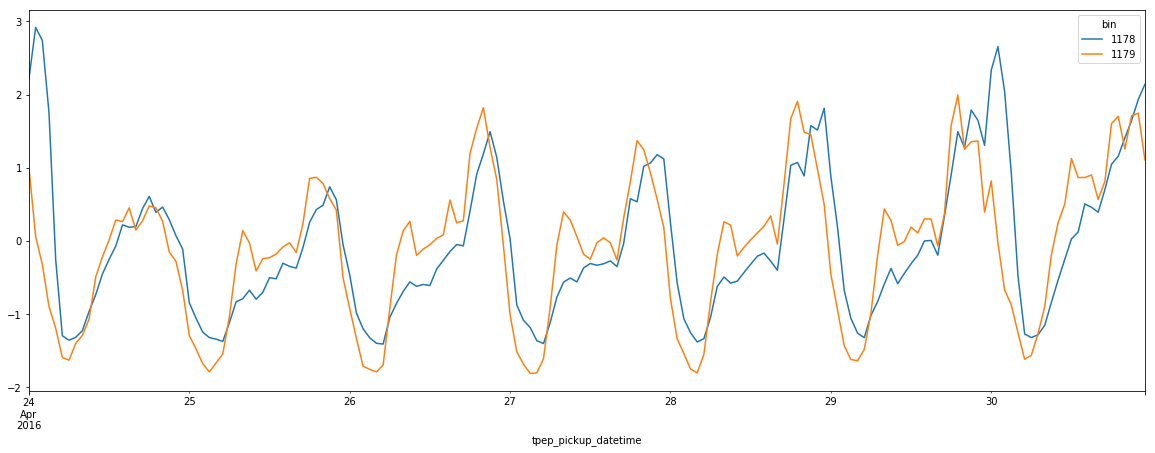

In [106]:
data4.iloc[-168:,[17,18]].plot(figsize=(20,7))

In [107]:
#3 Кластеризируем зоны
data5 = data4.T
data5.shape
z = linkage(data5, 'ward')

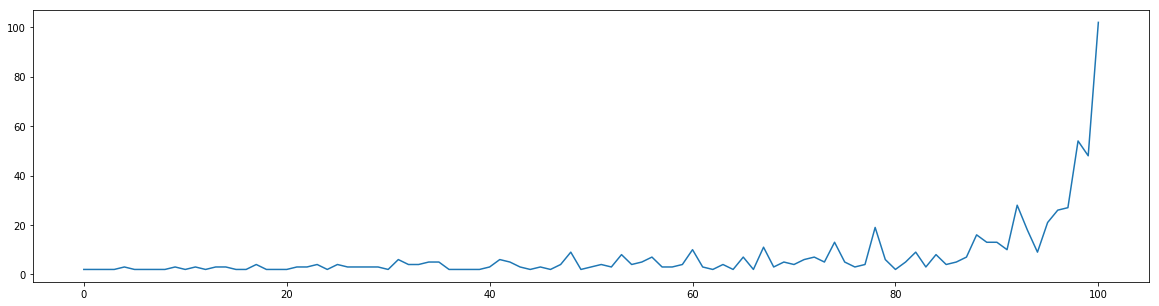

In [108]:
#заметим, что расстояние резко увеличивается при значении 80+
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(z[:,3])

In [1]:
z

NameError: name 'z' is not defined

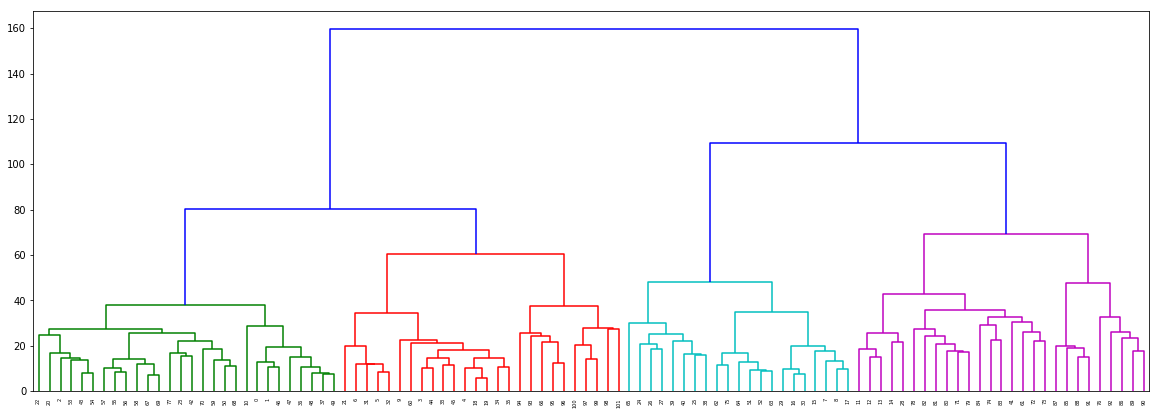

In [109]:
#нарисуем дендрограмму 
fig, ax = plt.subplots(figsize=(20,7))
dendrogram(z, color_threshold=80) #, p=10, truncate_mode = 'lastp') #color_threshold=4)
plt.show()

In [110]:
#добавим признак номер кластера 1-4
data5['cluster'] = fcluster(z, t=80, criterion = 'distance')

In [111]:
# хорошо, что количество зон в кластерах сравнимое
data5.cluster.value_counts()

1    28
4    27
2    26
3    21
Name: cluster, dtype: int64

In [112]:
# Построим графики стандартизированных рядов каждого кластера

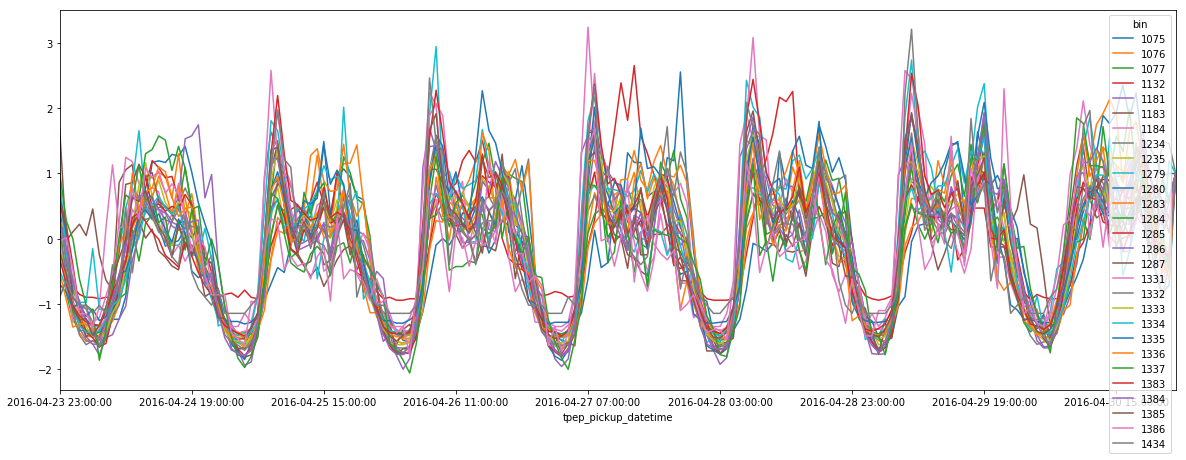

In [113]:
data5[data5.cluster==1].T[-170:].plot(figsize=(20,7))

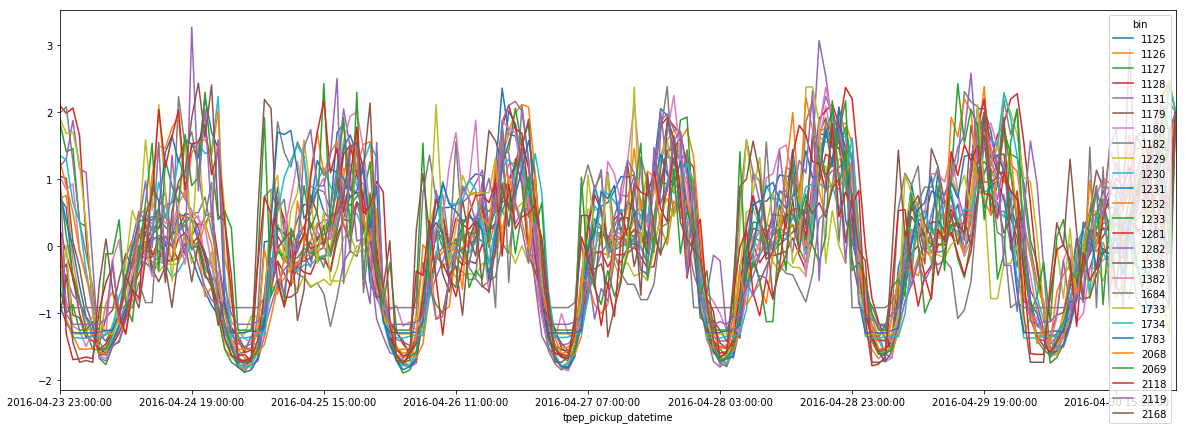

In [114]:
data5[data5.cluster==2].T[-170:].plot(figsize=(20,7))

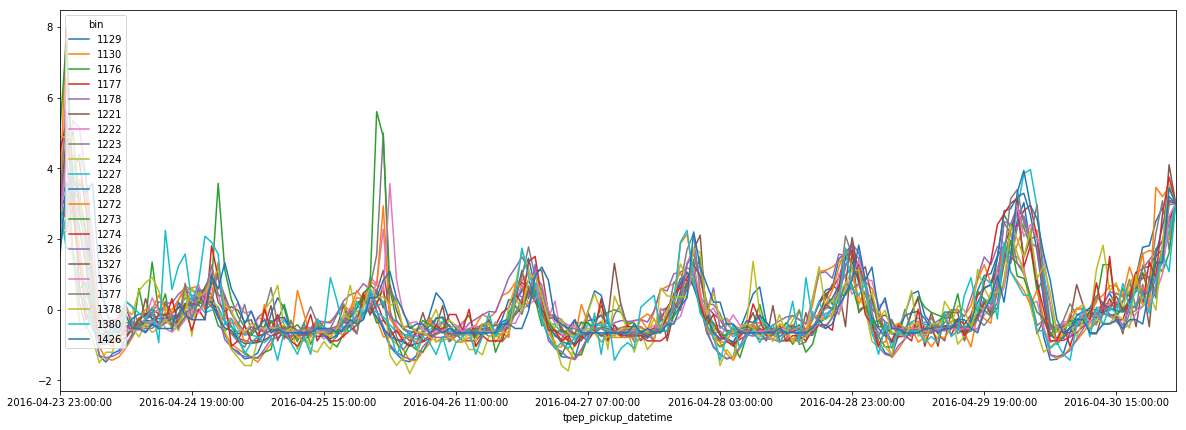

In [115]:
data5[data5.cluster==3].T[-170:].plot(figsize=(20,7))

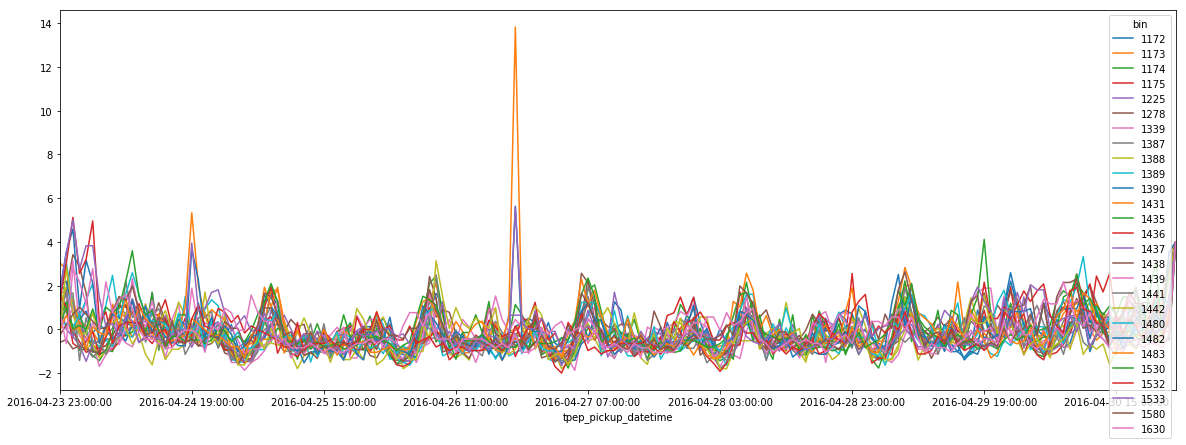

In [116]:
data5[data5.cluster==4].T[-170:].plot(figsize=(20,7))

In [117]:
#4 выбирем типичный ряд равный медиоанному кластера
data6 = pd.DataFrame()
for i in range(1,5):
    data6 = pd.concat([data6, data5[data5.cluster==i].T[:-1].median(axis=1).rename(str(i))], axis = 1, names = i)
data6[:2]

,1,2,3,4
tpep_pickup_datetime,,,,
2016-04-01 00:00:00,-0.946620,0.021594,0.967117,-0.109096
2016-04-01 01:00:00,-1.237956,-0.685924,0.362759,-0.289369


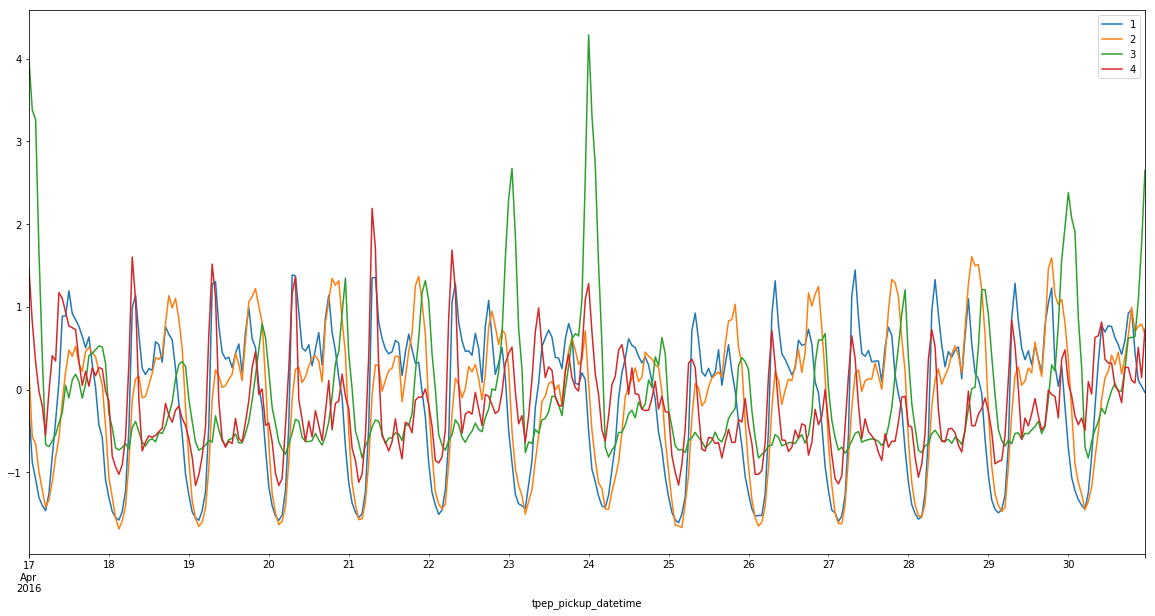

In [118]:
# визульано они отлчиются амплитудой колебаний и почасовой динамиков внтури дня
data6[-168*2:].plot(figsize=(20,10))

In [119]:
# посмотрим кластеры на карте
regions = pd.read_csv('C:/temp/6__/regions.csv',';')
polygons = []
for idx, i in regions[:].iterrows():
    polygons.append(Polygon([(i.west, i.south), (i.west, i.north), 
                           (i.east, i.north), (i.east, i.south)]))
crs = {'init': 'epsg:4326'}
regions_g = gpd.GeoDataFrame(regions[:].region, crs=crs, geometry=polygons)

In [120]:
data7 = data5[['cluster']].reset_index().rename(columns = {'bin':'region'})
regions_g = regions_g.merge(data7, on='region')

In [121]:
lat = 40.74777777777778
lon = -73.98583333333333
m = folium.Map([lat, lon], zoom_start=11, tiles = 'OpenStreetMap')#,
m.choropleth(
    geo_data = regions_g,#.geometry,
    data = regions_g,
    name = regions_g.region,
    columns = ['region','cluster'],
    key_on = 'feature.properties.region',
    fill_color = 'Set1',
    fill_opacity = 0.5,
    threshold_scale = [1, 2, 3, 4],
)
m

In [151]:
#сохраняем номера кластеров для 102 регионов
data5['cluster'].to_csv('C:/temp/6__/102_with_cluster.csv')
region_cluster = data5['cluster'].to_frame('cluster')

In [25]:
#region_cluster = pd.read_csv('C:/temp/6__/102_with_cluster.csv', header=None, index_col = [0], names=['cluster'])

#5 определяем центры кластеров и параметры модели для них

In [348]:
#5 определяем центры кластеров и параметры модели для них
cluster_centers = []
for ii in range(1,5):
    zz = centroid(data5[data5.cluster==ii])#, t=80, criterion = 'distance')
    cluster_centers.append(data5[data5.cluster==ii].index[int(zz[0,0])])

In [349]:
# считаем кодом выше в data данные по этим региоам
cluster_centers 

[1383, 1179, 1177, 1173]

In [55]:
#выбрали данные зоны из каждого кластера, аггрегируем данные
data1 = data[data.bin==1173].groupby(['tpep_pickup_datetime', 'bin'], as_index=False, sort=False )['VendorID'].count()
data1.rename(columns = {'VendorID':'Number'}, inplace = True)
data1.sort_values('tpep_pickup_datetime', inplace = True)
data1.drop('bin', axis = 1, inplace = True)

In [57]:
# дополняем данные пропущенными часами с нулями
time_line = pd.DataFrame(pd.date_range('2016-04-01', '2016-04-30 23:00', freq = 'H'))
time_line.rename(columns = {time_line.columns[0]: 'tpep_pickup_datetime'}, inplace = True)
data2 = time_line.set_index('tpep_pickup_datetime').join(data1.set_index('tpep_pickup_datetime'))
data2.fillna(0, inplace=True)

In [58]:
#создаем регрессионные признаки
data3 = data2.copy()
K = 2 #5
for i in range(1, K+1, 1):
    sin = []
    cos = []
    for j in range(1, data2.shape[0]+1, 1):
        sin.append(np.sin(j * 2 * np.pi * i / 168))
        cos.append(np.cos(j * 2 * np.pi * i / 168))
    data3['sin_'+str(i)] = sin
    data3['cos_'+str(i)] = cos

In [59]:
# делаем линейнйю регрессию числа поездок
m1 = smf.ols('Number ~ sin_1 + cos_1 + sin_2 + cos_2',# + sin_3 + cos_3 + sin_4 + cos_4 + sin_5 + cos_5',
             data=data3)
fitted = m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 Number   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3.967
Date:                Thu, 27 Dec 2018   Prob (F-statistic):            0.00343
Time:                        09:15:30   Log-Likelihood:                -2999.8
No. Observations:                 720   AIC:                             6010.
Df Residuals:                     715   BIC:                             6033.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.5867      0.586     33.421      0.0

C:\Users\Andrey\Anaconda3\lib\site-packages\patsy\util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
C:\Users\Andrey\Anaconda3\lib\site-packages\patsy\util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):


In [60]:
# считаем остатки после регрессии
data4 = data3.copy()
data4['Num_2'] = data4['Number'] - fitted.predict()

In [61]:
# делаем суточное дифферецирование
data5 = data4.copy()
data5['Num_2_24'] = data5.Num_2 - data4.Num_2.shift(24)

In [62]:
# делаем дифферецирование к ближайшей точке
data6 = data5.copy()
data6['Num_2_diff'] = data5.Num_2_24 - data5.Num_2_24.shift(1)

Критерий Дики-Фуллера: p=0.000000


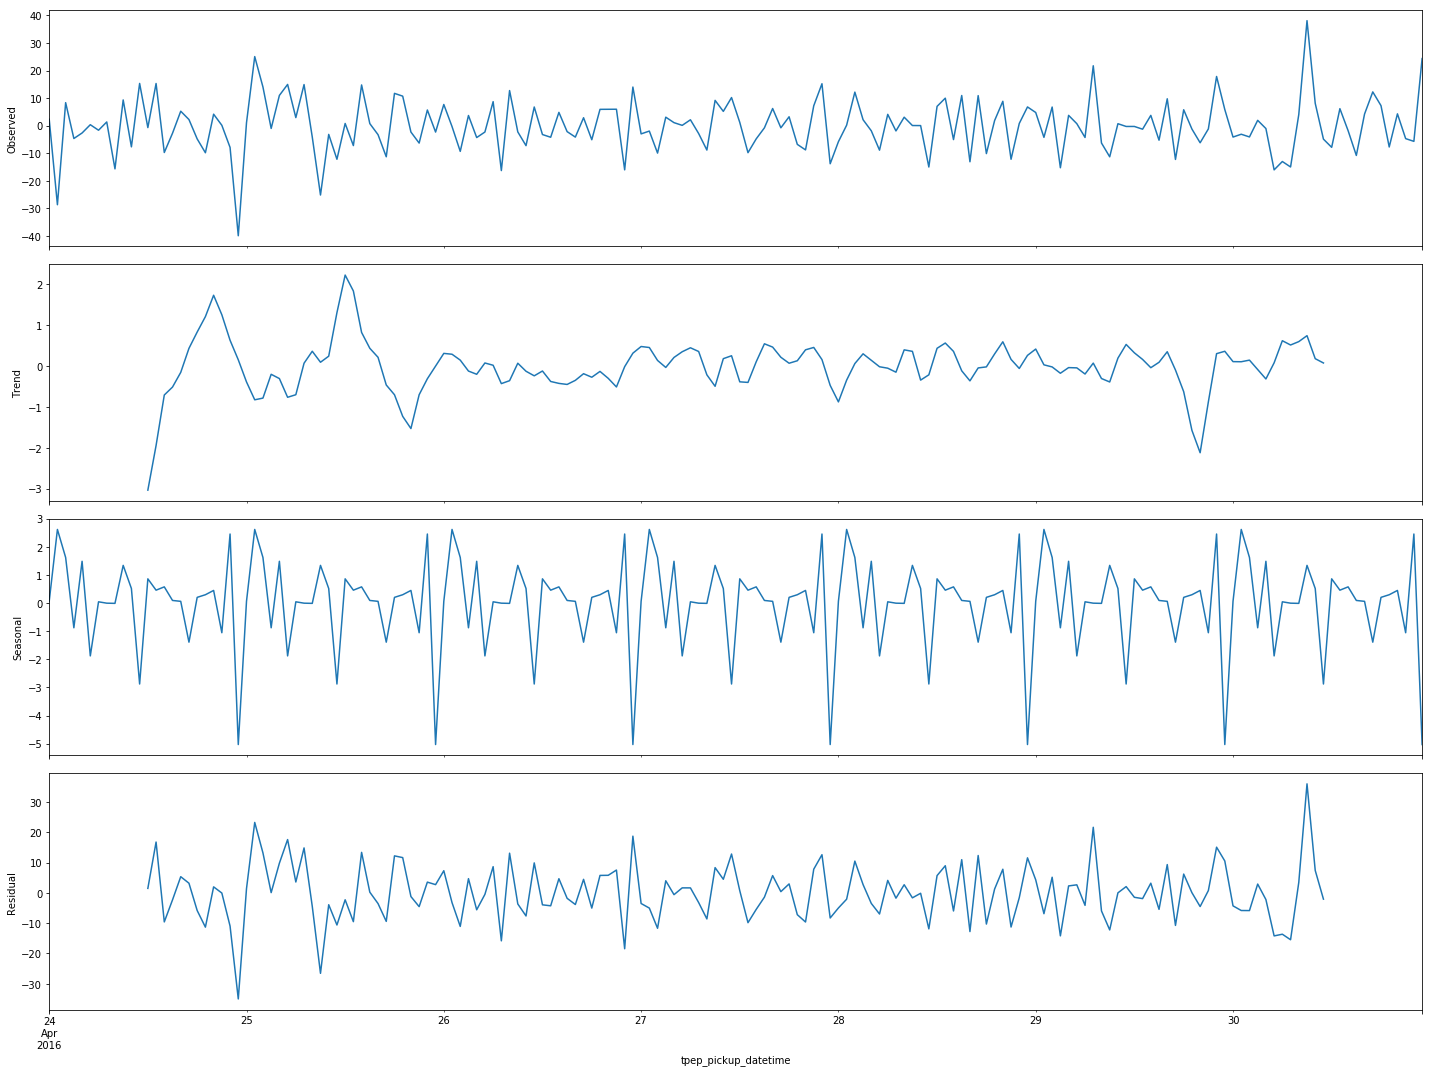

In [63]:
plt.rcParams['figure.figsize']=(20,15)
sm.tsa.seasonal_decompose(data6.Num_2_diff[25:][-168:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data6.Num_2_diff[25:])[1])

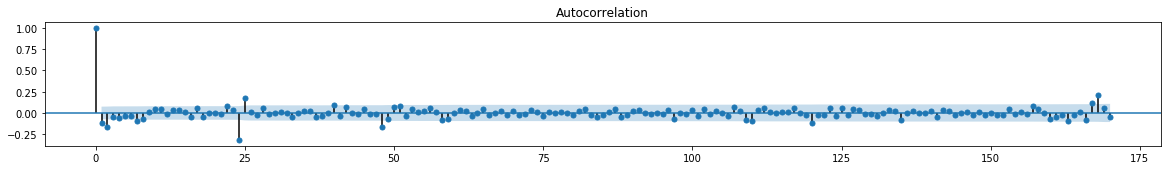

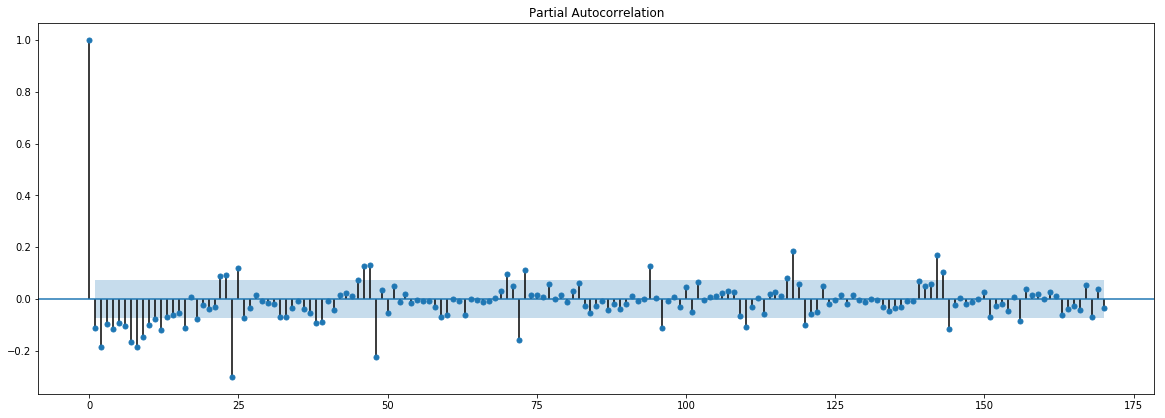

In [64]:
# строим ACF и PCF остатков ряда
fig, ax = plt.subplots(figsize=(20,5))
#plt.figure(figsize(20,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data6.Num_2_diff[25:].values.squeeze(), lags=170, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data6.Num_2_diff[25:].values.squeeze(), lags=170, ax=ax)
plt.show()

In [68]:
#Начальные приближения: Q=1, q=6, P=2, p=6
ps = range(0, 3)
d=1
qs = range(0, 3)
Ps = range(1, 3)
D=1
Qs = range(0, 2)

In [66]:
data6 = data6[-168*4:]

In [69]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [70]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data6['Number'], exog = data6[['sin_1', 'cos_1', 'sin_2', 'cos_2']],
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 2h 36min 19s


In [71]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters          aic
31  (2, 1, 2, 1)  4730.241126
23  (1, 2, 2, 1)  4734.359519
35  (2, 2, 2, 1)  4736.268298
29  (2, 1, 1, 1)  4740.129692
21  (1, 2, 1, 1)  4743.559830
                                 Statespace Model Results                                 
Dep. Variable:                             Number   No. Observations:                  672
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 24)   Log Likelihood               -2354.121
Date:                            Thu, 27 Dec 2018   AIC                           4730.241
Time:                                    12:11:52   BIC                           4779.854
Sample:                                04-03-2016   HQIC                          4749.455
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

In [ ]:
# для кластера-1 выбираем 3,1,1,1
# для кластера-2 выбираем 1,1,1,1 (3,1,2,1    1,1,2,1)
# для кластера-3 выбираем 1,2,1,1 ((0, 2, 1, 1)(0, 3, 1, 1))
# для кластера-4 выбираем 2,1,1,1

6 для каждого региона делаем прогноз на май

In [11]:
parameters_list_4 = [
    (3,1,1,1),
    (1,1,1,1),
    (1,2,1,1),
    (2,1,1,1)
]
d = 1
D = 1

In [13]:
region_cluster = pd.read_csv('C:/temp/6__/102_with_cluster.csv', header=None, index_col = [0], names=['cluster'])

In [75]:
regions_not_done = [1130, 1178, 1233, 1278, 1327, 1377, 1378, 1387, 1390, 1438, 1630]

In [77]:
%%time
results = pd.DataFrame()
warnings.filterwarnings('ignore')

for j in regions_not_done[1:]: #data3.columns[:]:
    #clstr = region_cluster[region_cluster.index == j].iloc[0,0]
    clstr = 1
    param = parameters_list_4[clstr-1]
    data_ = data3.loc[:,j].to_frame('Number')
    
    #создаем регрессионные признаки
    K = 2 #5
    for i in range(1, K+1, 1):
        sin = []
        cos = []
        for jj in range(1, data_.shape[0]+1, 1):
            sin.append(np.sin(jj * 2 * np.pi * i / 168))
            cos.append(np.cos(jj * 2 * np.pi * i / 168))
        data_['sin_'+str(i)] = sin
        data_['cos_'+str(i)] = cos
    
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data_['Number'], exog = data_[['sin_1', 'cos_1', 'sin_2', 'cos_2']],
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим  регион, на котором модель не обучилось
    except ValueError:
        print(j, ' - wrong region:', clstr)
        continue
        
    start = '2016-05-01 00:00'
    end = '2016-05-31 23:00'
    time_line = pd.DataFrame(pd.date_range(start, end, freq = 'H'))
    time_line.rename(columns = {time_line.columns[0]: 'tpep_pickup_datetime'}, inplace = True) 

    K = 2 #5
    for i in range(1, K+1, 1):
            sin = []
            cos = []
            for jj in range(1, data_.shape[0]+1+744, 1):
                sin.append(np.sin(jj * 2 * np.pi * i / 168))
                cos.append(np.cos(jj * 2 * np.pi * i / 168))
            time_line['sin_'+str(i)] = sin[-744:]
            time_line['cos_'+str(i)] = cos[-744:]

    forecast = model.get_forecast(steps = 744, exog = time_line[['sin_1', 'cos_1', 'sin_2', 'cos_2']])\
                                 .predicted_mean.to_frame(str(j))
    results = results.join(forecast, how='outer')
    print(j)
    
warnings.filterwarnings('default')

1178
1233
1278
1327
1377
1378
1387
1390
1438
1630
Wall time: 41min 49s


In [78]:
results.to_csv('C:/temp/6__/FC_may_6.csv')

In [149]:
# читаем сохраненные результаты расчетов из файлов
data_may =  pd.read_csv('C:/temp/6__/FC_may_1.csv', index_col=[0], parse_dates=[0])
files = [
        'C:/temp/6__/FC_may_2.csv',
        'C:/temp/6__/FC_may_3.csv',
        'C:/temp/6__/FC_may_4.csv',
        'C:/temp/6__/FC_may_5.csv',
        'C:/temp/6__/FC_may_6.csv',
         ]
for file in files:
    data_may = data_may.join(pd.read_csv(file, index_col=[0], parse_dates=[0]))
data_may = data_may[[str(i) for i in list(data3.columns)]]

(744, 102)

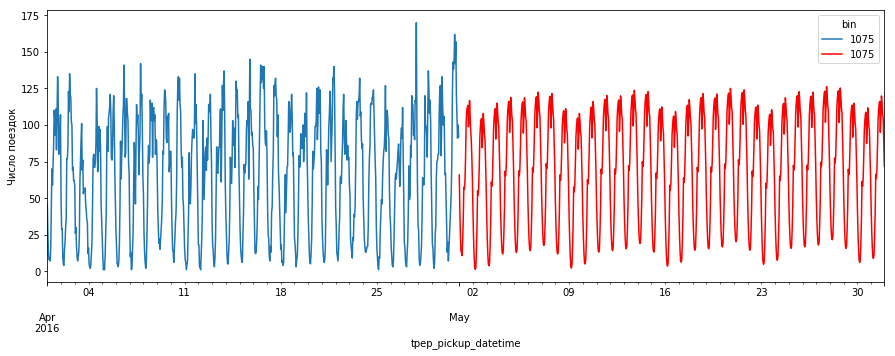

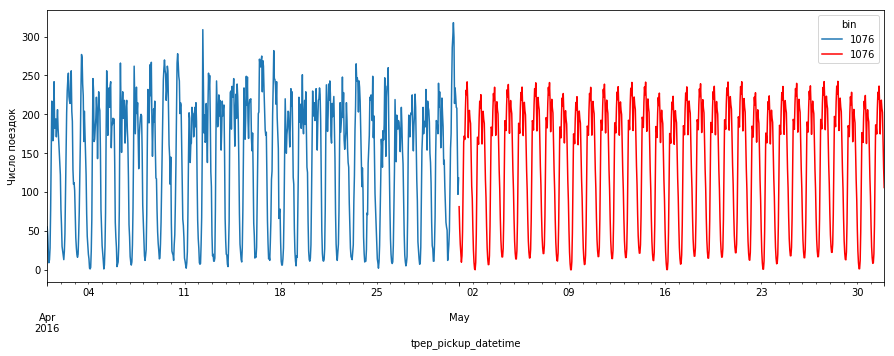

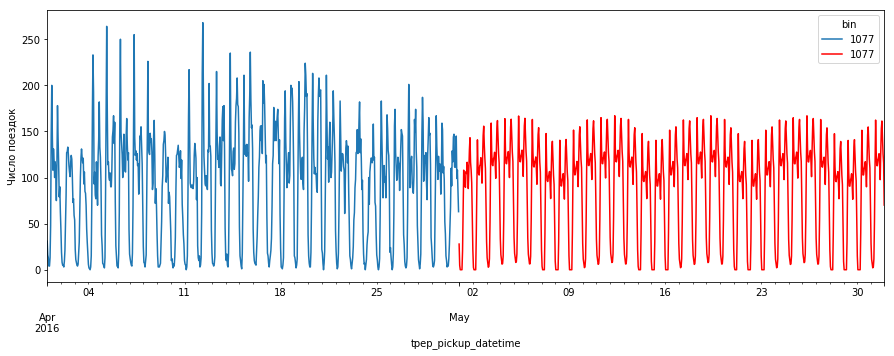

In [190]:
#построим графики исходного ряда и предсказаний по модели
for jj in data3.columns[:3]: #= 1075
    fig, ax = plt.subplots(figsize=(15,5))
    data3[[jj]][:].plot(ax=ax)
    data_may[[str(jj)]][:].plot(ax=ax,color='r')
    plt.ylabel('Число поездок')
plt.show()

In [188]:
# заметим, что есть регионы, в которых модель требует улучшения и 
# заменим отрицательный прогноз на нули
data_may[data_may < 0 ] = 0

In [189]:
data_may[data_may < 0].count().sum()

0

In [193]:
data_may.to_csv('C:/temp/6__/FC_may_all.csv')

In [194]:
#считаем отклонения 
# читаем данные мая кодом выше в data3

In [233]:
data_3 = abs(np.array(data3) - np.array(data_may))
s = 0
for i in range(0,739):
    s += data_3[i:i+6,:].sum()
print('ошибка : ', s / 102 / 739/ 6 )

ошибка :  47.28426695133748


In [234]:
# Ошибка все еще большая, но ресурсов на улучшения уже нет (
# 7 далее считаем прогноз июня на данных по май, уже загруженных в data3

In [250]:
%%time
results = pd.DataFrame()
warnings.filterwarnings('ignore')

for j in data3.columns[52:]:  #regions_not_done[:]: 
    clstr = region_cluster[region_cluster.index == j].iloc[0,0]
    #clstr = 1
    param = parameters_list_4[clstr-1]
    data_ = data3.loc[:,j].to_frame('Number')
    
    #создаем регрессионные признаки
    K = 2 #5
    for i in range(1, K+1, 1):
        sin = []
        cos = []
        for jj in range(1, data_.shape[0]+1, 1):
            sin.append(np.sin(jj * 2 * np.pi * i / 168))
            cos.append(np.cos(jj * 2 * np.pi * i / 168))
        data_['sin_'+str(i)] = sin
        data_['cos_'+str(i)] = cos
    
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data_['Number'], exog = data_[['sin_1', 'cos_1', 'sin_2', 'cos_2']],
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим  регион, на котором модель не обучилось
    except ValueError:
        print(j, ' - wrong region:', clstr)
        continue
        
    start = '2016-06-01 00:00'
    end = '2016-06-30 23:00'
    time_line = pd.DataFrame(pd.date_range(start, end, freq = 'H'))
    time_line.rename(columns = {time_line.columns[0]: 'tpep_pickup_datetime'}, inplace = True) 

    K = 2 #5
    for i in range(1, K+1, 1):
            sin = []
            cos = []
            for jj in range(1, data_.shape[0]+1+720, 1):
                sin.append(np.sin(jj * 2 * np.pi * i / 168))
                cos.append(np.cos(jj * 2 * np.pi * i / 168))
            time_line['sin_'+str(i)] = sin[-720:]
            time_line['cos_'+str(i)] = cos[-720:]

    forecast = model.get_forecast(steps = 720, exog = time_line[['sin_1', 'cos_1', 'sin_2', 'cos_2']])\
                                 .predicted_mean.to_frame(str(j))
    results = results.join(forecast, how='outer')
    print(j)
    
warnings.filterwarnings('default')

1129
1130
1173
1174
1175
1178
1327
1338
1387
1388
1389
1390
1435
1437
1482
Wall time: 3h 18min 11s


In [251]:
#сохраняем промежуточные результаты
results.to_csv('C:/temp/6__/FC_june_4.csv')

In [249]:
regions_not_done = [1129, 1130, 1173, 1174, 1175, 1178, 1327, 1338, 
                    1387, 1388, 1389, 1390, 1435, 1437, 1482]

In [255]:
# читаем сохраненные результаты расчетов из файлов
data_june =  pd.read_csv('C:/temp/6__/FC_june_1.csv', index_col=[0], parse_dates=[0])
files = [
        'C:/temp/6__/FC_june_2.csv',
        'C:/temp/6__/FC_june_3.csv',
        'C:/temp/6__/FC_june_4.csv',
        #'C:/temp/6__/FC_june_5.csv',
        #'C:/temp/6__/FC_june_6.csv',
         ]
for file in files:
    data_june = data_june.join(pd.read_csv(file, index_col=[0], parse_dates=[0]))
data_june = data_june[[str(i) for i in data3.columns]]

In [256]:
data_june.shape

(720, 102)

In [257]:
data_june[:2]

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2016-06-01 00:00:00,27.726414,45.111345,29.775179,35.179250,91.044446,116.650128,219.252558,287.575460,408.183102,87.608052,...,6.947075,0.607513,4.690931,214.638588,6.119537,84.583303,6.582474,188.847421,17.264273,111.753919
2016-06-01 01:00:00,11.049948,28.608913,7.548671,23.286396,49.529872,42.824999,137.928386,231.194186,388.804945,85.318754,...,7.110598,-2.537577,2.049738,44.012740,-52.784515,25.018114,4.379039,94.843013,5.054982,54.652943


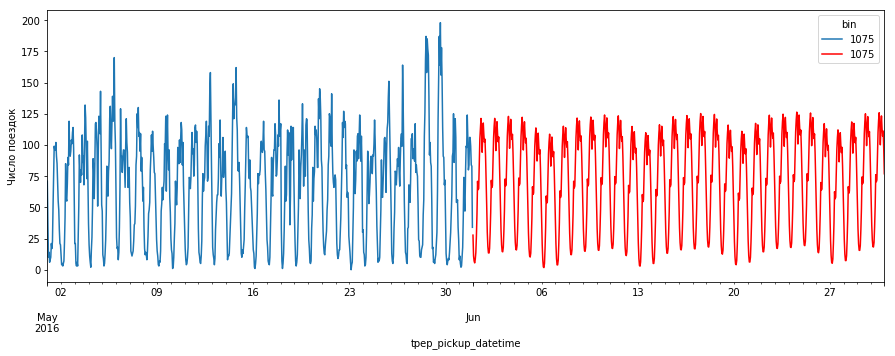

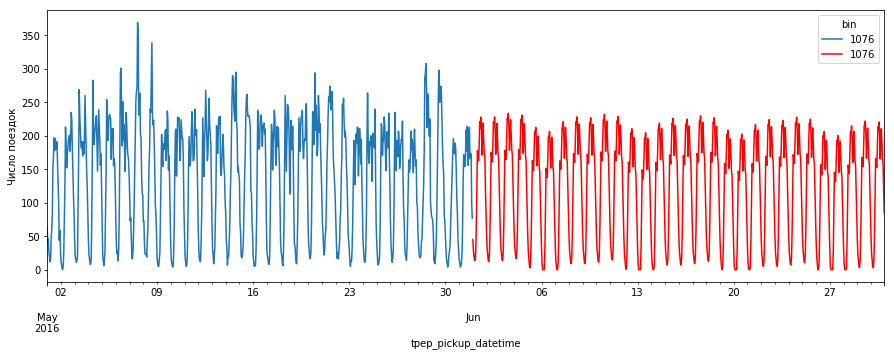

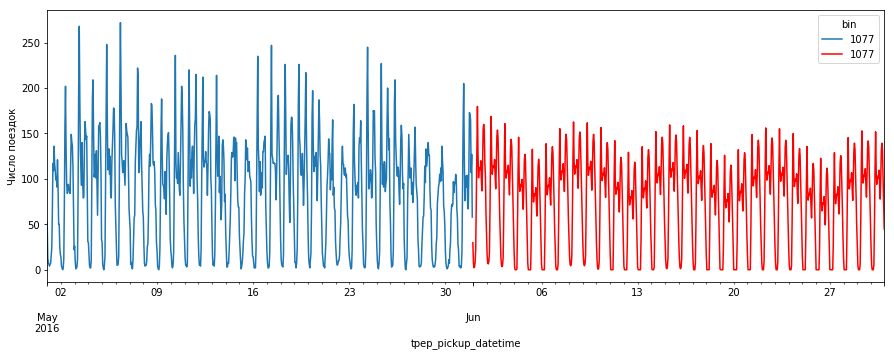

In [265]:
#построим графики исходного ряда и предсказаний по модели
for jj in data3.columns[:3]: #= 1075
    fig, ax = plt.subplots(figsize=(15,5))
    data3[[jj]][:].plot(ax=ax)
    data_june[[str(jj)]][:].plot(ax=ax,color='r')
    plt.ylabel('Число поездок')
plt.show()

In [260]:
# заметим, что есть регионы, в которых модель требует cущественного улучшения и 
# заменим отрицательный прогноз на нули
data_june[data_june < 0 ] = 0

In [261]:
data_june[data_june < 0].count().sum()

0

In [262]:
data_june.to_csv('C:/temp/6__/FC_june_all.csv')

In [ ]:
#7 формируем файл для загрузки на Kaggle

In [284]:
time_line = pd.DataFrame(pd.date_range('2016-05-31 23:00', '2016-06-30 17:00', freq = 'H')).iloc[:,0].to_frame('date')

In [295]:
data_june.shape

(720, 102)

In [343]:
forecast_list = []
for tt in time_line.date[:]:
    for ii in data_june.columns[:]:
        for jj in range(1,7)[:]:
            id = str(ii)+'_'+str(tt)[:10]+'_'+str(int(str(tt)[11:13]))+'_'+str(jj)
            val = data_june.loc[tt + timedelta(hours=jj), ii]
            forecast_list.append([id, round(val, 0)])

In [344]:
forecast_pd = pd.DataFrame(forecast_list)
#.to_csv('C:/temp/6__/Kaggle_submission.csv', header=False, index=False)

In [345]:
forecast_pd.columns = ['id', 'y']

In [346]:
forecast_pd.to_csv('C:/temp/6__/Kaggle_submission.csv', index=False) #header=False,

# ниже сслылка на успешную загрузку прогноза Июня на Kaggle
https://www.kaggle.com/atom216/competitions
https://www.kaggle.com/c/yellowtaxi/leaderboard (AndreyT на 110 месте)
(https://www.kaggle.com/submissions/9657238/9657238.raw)